# Финальная работа, Ноутбук с моделью

## Импортируем необходимые пакеты

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  # Импорт NumPy
import seaborn as sns
from datetime import datetime


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression



## Считываем данные в dataframe

In [61]:
df_sessions = pd.read_csv('data/ga_sessions.csv', low_memory=False)
df_sessions.shape

(1860042, 18)

In [62]:
df_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [63]:
df_hits = pd.read_csv('data/ga_hits.csv', low_memory=False)

In [64]:
df_hits.shape

(15726470, 11)

In [65]:
df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [66]:
target_actions = [
    'sub_car_claim_click', 
    'sub_car_claim_submit_click',
    'sub_open_dialog_click', 
    'sub_custom_question_submit_click',
    'sub_call_number_click', 
    'sub_callback_submit_click', 
    'sub_submit_success',
    'sub_car_request_submit_click'
]

# Создаем бинарный признак event_target
df_hits['event_target'] = df_hits['event_action'].apply(
    lambda x: 1 if pd.notna(x) and x in target_actions else 0
)


In [67]:
df_hits['event_target']=df_hits['event_target'].astype(int)

In [68]:
df_hits.drop(['event_action'], axis=1, inplace=True)

In [69]:
df_hits_1=df_hits.groupby('session_id')['event_target'].max()

In [70]:
merged_df = pd.merge(
    df_sessions,
    df_hits_1,
    on='session_id',  # или другой общий столбец
    how='left'       # тип соединения: 'inner', 'outer', 'left', 'right'
)
merged_df.shape

(1860042, 19)

In [71]:
 merged_df['event_target'] = merged_df['event_target'].fillna(0).astype(int) 

In [72]:
# Преобразование столбца visit_date в тип datetime
merged_df['visit_date'] = pd.to_datetime(merged_df['visit_date'])

merged_df['month'] = merged_df['visit_date'].dt.month
merged_df['day_of_week'] = merged_df['visit_date'].dt.dayofweek  # 0=понедельник, 6=воскресенье


In [73]:
# 1. Извлекаем час из времени
merged_df['hour'] = pd.to_datetime(merged_df['visit_time'], format='%H:%M:%S').dt.hour

# 2. Создаем числовой признак (кодировку)
merged_df['time_of_day'] = (
    merged_df['hour']
    .apply(lambda x: 
        0 if 0 <= x < 6 else    # Ночь (0-6)
        1 if 6 <= x < 12 else    # Утро (6-12)
        2 if 12 <= x < 18 else   # День (12-18)
        3                        # Вечер (18-24)
    )
)


In [74]:
# Замена некорректных значений на NaN и удаление строк с ними
merged_df['device_screen_resolution'] = merged_df['device_screen_resolution'].replace('(not set)', pd.NA)
merged_df = merged_df.dropna(subset=['device_screen_resolution'])

# Безопасное вычисление пикселей с обработкой возможных ошибок
merged_df['screen_pixels'] = (
    merged_df['device_screen_resolution']
    .str.split('x')
    .apply(lambda x: int(x[0]) * int(x[1]) if len(x) == 2 else pd.NA)
)

In [75]:
# Добавление признака "квартал" (1-4)
merged_df['quarter'] = merged_df['visit_date'].dt.quarter

# Добавление признака "номер недели в месяце" (1-4)
merged_df['week_in_month'] = (merged_df['visit_date'].dt.day - 1) // 7 + 1

In [76]:
merged_df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,...,geo_country,geo_city,event_target,month,day_of_week,hour,time_of_day,screen_pixels,quarter,week_in_month
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,Russia,Zlatoust,0,11,2,14,2,259200,4,4
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,...,Russia,Moscow,0,11,6,8,1,328790,4,2
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,Russia,Krasnoyarsk,0,12,1,2,0,259200,4,4
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,...,Russia,Moscow,0,5,5,5,0,308898,2,5
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,...,Russia,Moscow,0,5,5,5,0,308898,2,5


In [77]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1860034 entries, 0 to 1860041
Data columns (total 26 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   session_id                object        
 1   client_id                 object        
 2   visit_date                datetime64[ns]
 3   visit_time                object        
 4   visit_number              int64         
 5   utm_source                object        
 6   utm_medium                object        
 7   utm_campaign              object        
 8   utm_adcontent             object        
 9   utm_keyword               object        
 10  device_category           object        
 11  device_os                 object        
 12  device_brand              object        
 13  device_model              object        
 14  device_screen_resolution  object        
 15  device_browser            object        
 16  geo_country               object        
 17  geo_city     

## EDA

In [78]:
merged_df.describe()

,visit_date,visit_number,event_target,month,day_of_week,hour,time_of_day,screen_pixels,quarter,week_in_month
count,1860034,1.860034e+06,1.860034e+06,1.860034e+06,1.860034e+06,1.860034e+06,1.860034e+06,1.860034e+06,1.860034e+06,1.860034e+06
mean,2021-09-26 11:45:56.872186112,2.712812e+00,2.705004e-02,9.326663e+00,2.799548e+00,1.361912e+01,1.848768e+00,6.108804e+05,3.378391e+00,2.876658e+00
min,2021-05-19 00:00:00,1.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00
25%,2021-08-02 00:00:00,1.000000e+00,0.000000e+00,8.000000e+00,1.000000e+00,1.000000e+01,1.000000e+00,2.808000e+05,3.000000e+00,2.000000e+00
50%,2021-10-06 00:00:00,1.000000e+00,0.000000e+00,1.000000e+01,3.000000e+00,1.400000e+01,2.000000e+00,3.344430e+05,4.000000e+00,3.000000e+00
75%,2021-11-23 00:00:00,2.000000e+00,0.000000e+00,1.100000e+01,4.000000e+00,1.900000e+01,3.000000e+00,3.769800e+05,4.000000e+00,4.000000e+00
max,2021-12-31 00:00:00,5.640000e+02,1.000000e+00,1.200000e+01,6.000000e+00,2.300000e+01,3.000000e+00,3.200000e+07,4.000000e+00,5.000000e+00
std,NaN,1.182910e+01,1.622293e-01,2.199775e+00,1.983559e+00,6.121916e+00,9.814734e-01,7.151551e+05,7.283903e-01,1.284855e+00


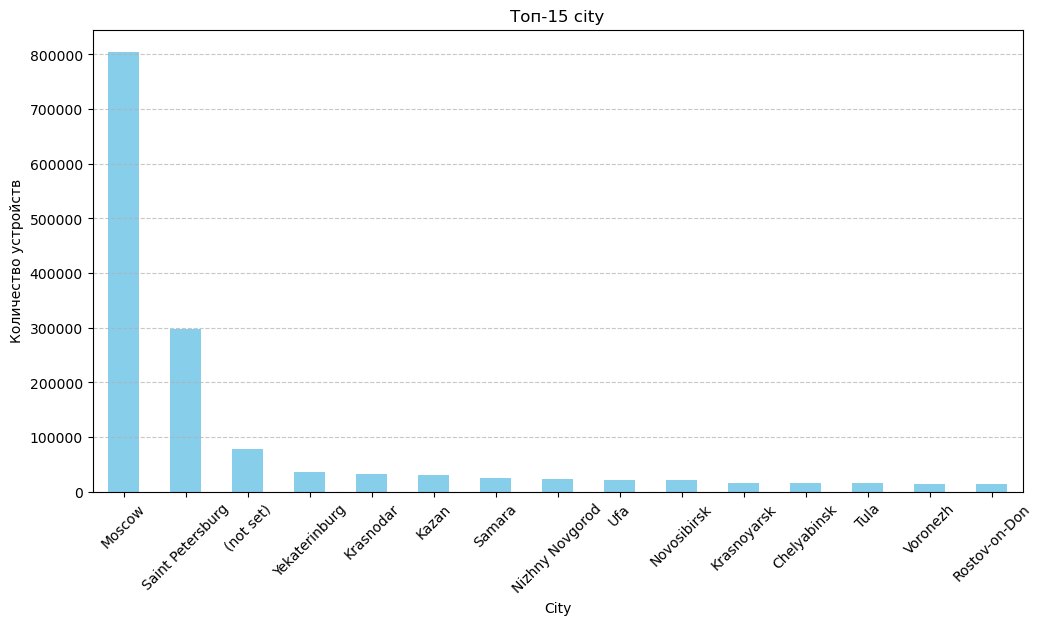

In [79]:
top_n = 15  # Показать топ-10 city
city_counts = merged_df['geo_city'].value_counts()
top_city = city_counts.head(top_n)

plt.figure(figsize=(12, 6))
top_city.plot(kind='bar', color='skyblue')
plt.title(f'Топ-{top_n} city')
plt.xlabel('City')
plt.ylabel('Количество устройств')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

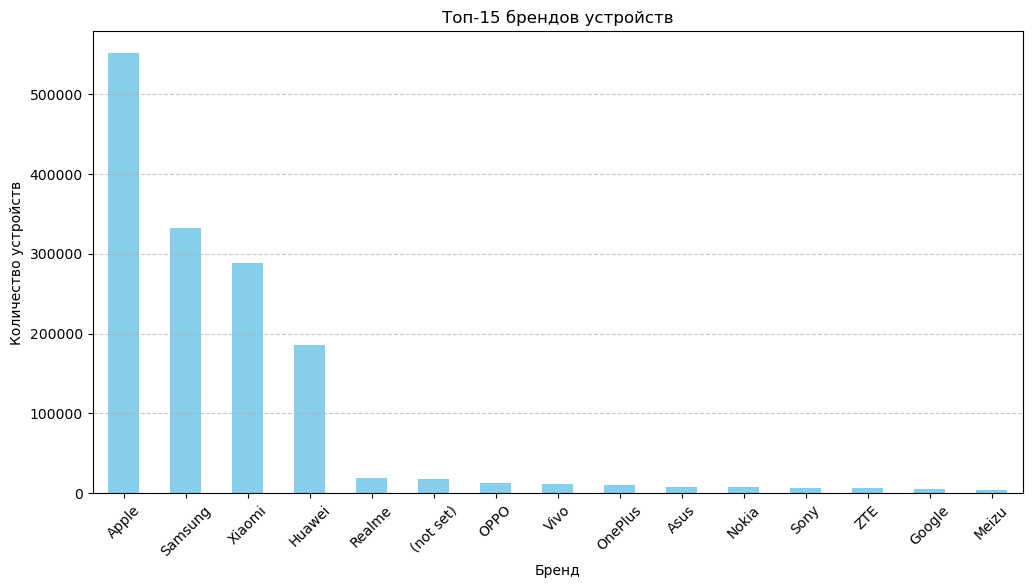

In [80]:
top_n = 15  # Показать топ-10 брендов
brand_counts = merged_df['device_brand'].value_counts()
top_brands = brand_counts.head(top_n)

plt.figure(figsize=(12, 6))
top_brands.plot(kind='bar', color='skyblue')
plt.title(f'Топ-{top_n} брендов устройств')
plt.xlabel('Бренд')
plt.ylabel('Количество устройств')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [81]:
merged_df['device_brand'].value_counts()[:15]

device_brand
Apple        551088
Samsung      332193
Xiaomi       288364
Huawei       185853
Realme        19058
(not set)     17544
OPPO          13504
Vivo          11740
OnePlus        9965
Asus           7929
Nokia          7285
Sony           6459
ZTE            6365
Google         5150
Meizu          3750
Name: count, dtype: int64

In [82]:
merged_df['device_os'].value_counts()

device_os
Android          464052
iOS              207104
Windows           88307
Macintosh         24824
Linux              5120
(not set)           364
Chrome OS            83
BlackBerry           27
Tizen                 7
Samsung               4
Windows Phone         4
Firefox OS            3
Nokia                 3
Name: count, dtype: int64

In [83]:
merged_df['device_category'].value_counts()

device_category
mobile     1474863
desktop     366863
tablet       18308
Name: count, dtype: int64

In [84]:
merged_df['device_browser'].value_counts()[:15]

device_browser
Chrome                              1013428
Safari                               478562
YaBrowser                            133311
Safari (in-app)                       69912
Android Webview                       55369
Samsung Internet                      47309
Opera                                 26817
Firefox                               16588
Edge                                  16065
UC Browser                              871
Android Runtime                         392
Mozilla Compatible Agent                362
[FBAN                                   269
Instagram 208.0.0.32.135 Android        140
Instagram 209.0.0.21.119 Android        111
Name: count, dtype: int64

## Подготовка данных

### Обработка пропусков в данных

In [85]:
df_prepared=merged_df.copy()


In [86]:
df_prepared.reset_index(drop=True, inplace=True)

In [87]:
# Есть ли пропуски?

df_prepared.isnull().sum().sort_values()

session_id                        0
screen_pixels                     0
time_of_day                       0
hour                              0
day_of_week                       0
month                             0
event_target                      0
geo_city                          0
geo_country                       0
device_browser                    0
device_screen_resolution          0
quarter                           0
week_in_month                     0
device_category                   0
utm_medium                        0
visit_number                      0
visit_time                        0
visit_date                        0
client_id                         0
utm_source                       97
utm_campaign                 219603
utm_adcontent                335615
device_brand                 367178
device_os                   1070132
utm_keyword                 1082055
device_model                1843696
dtype: int64

In [88]:
import missingno as msno

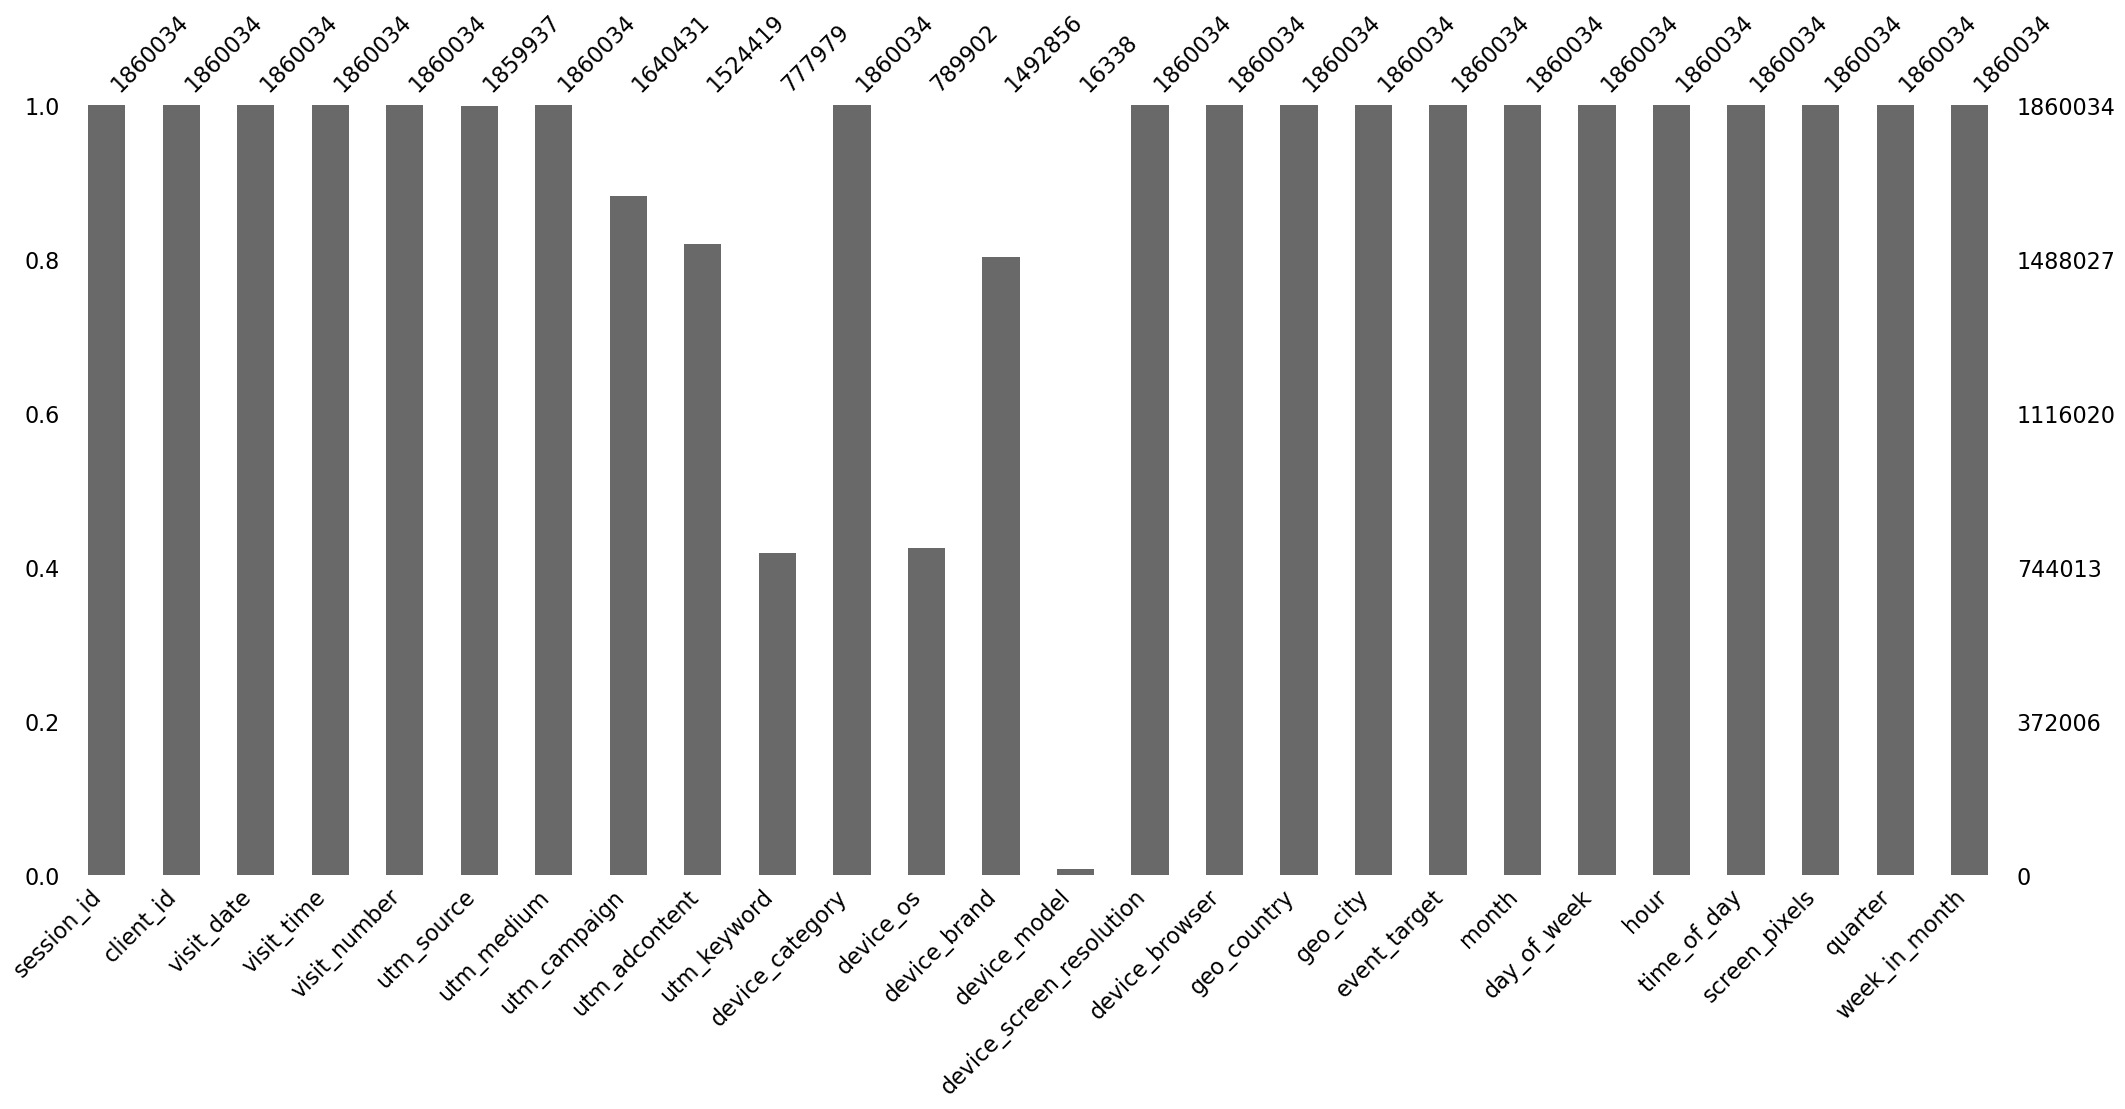

In [89]:
msno.bar(df_prepared);

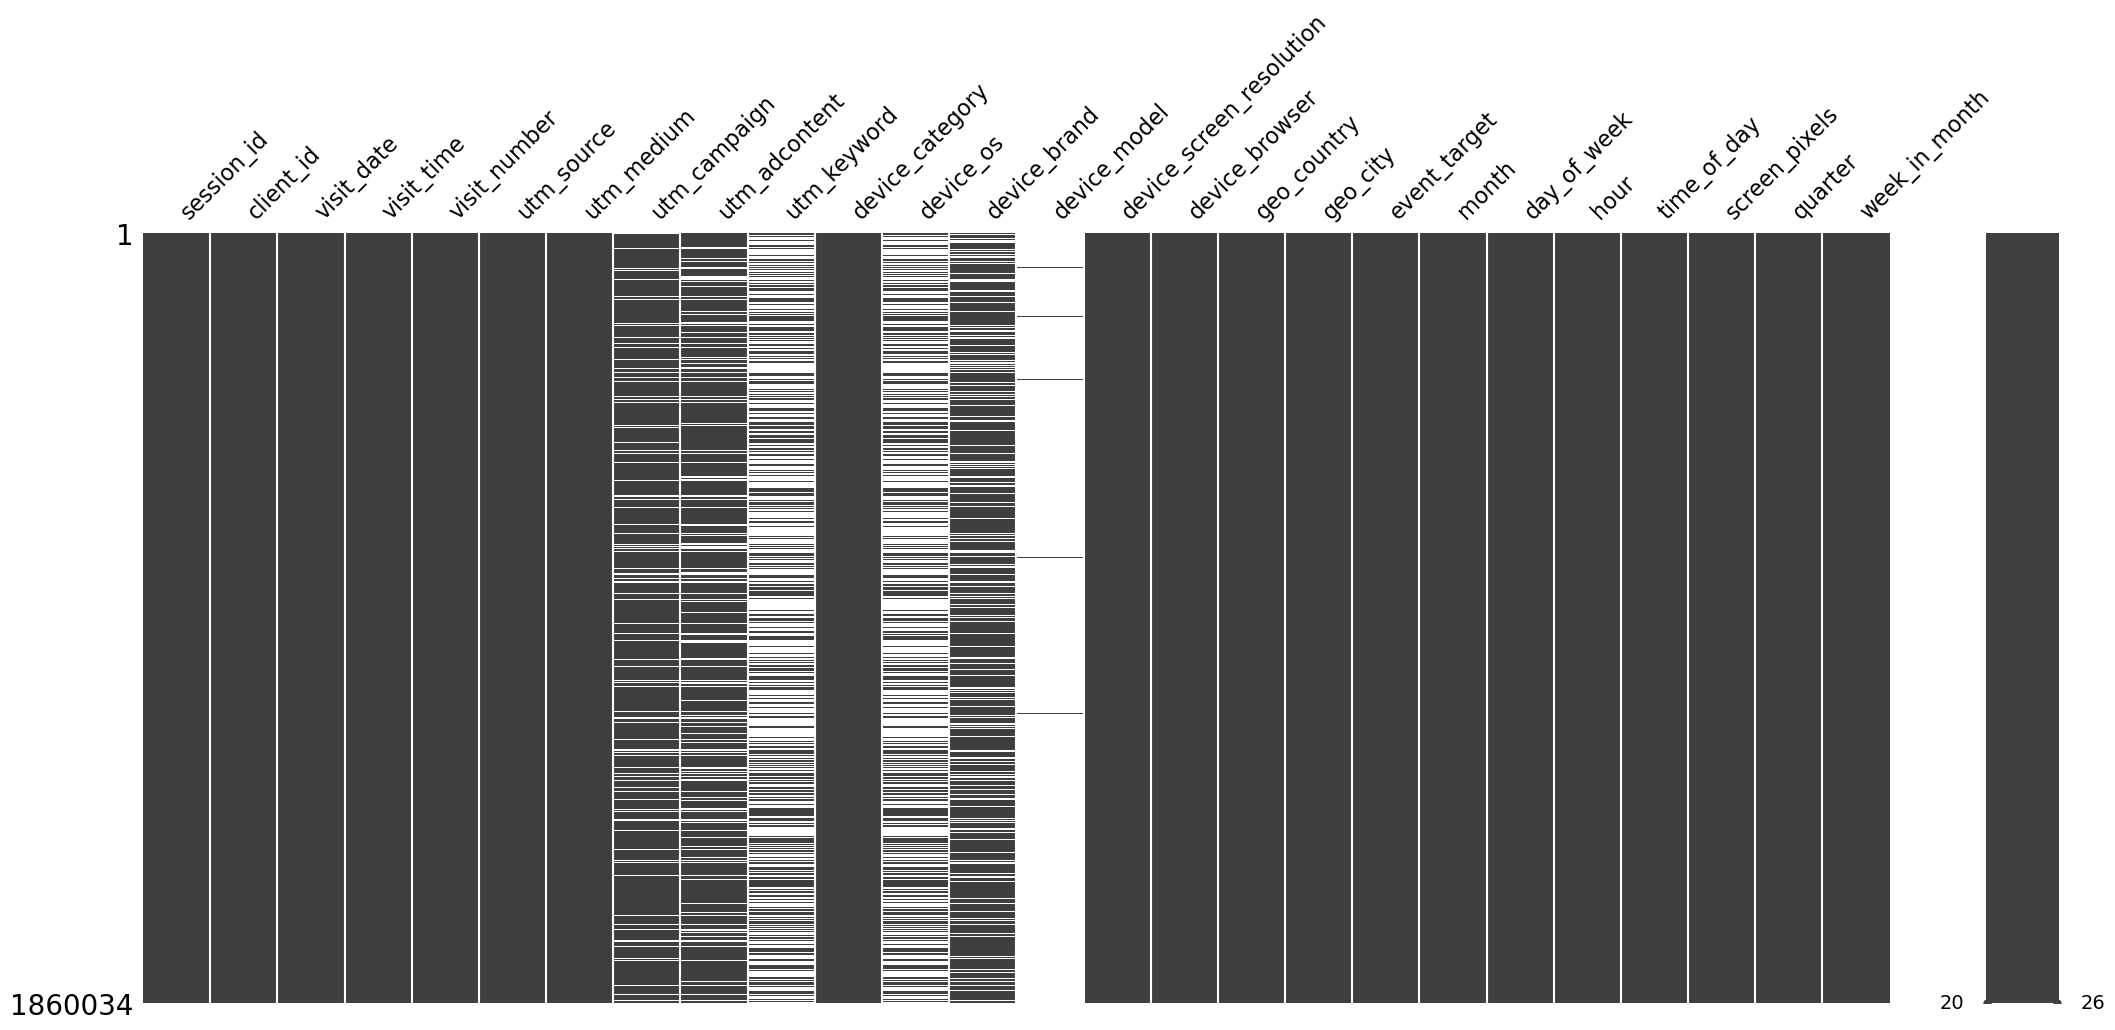

In [90]:
msno.matrix(df_prepared);

In [91]:
df_prepared['device_model'] = df_prepared['device_model'].fillna('other')


# Сохраним в переменную numerical имена всех числовых признаков нашего датасета
numerical = df_prepared.select_dtypes(include=['int64', 'float64']).columns

# Сохраним в переменную categorical имена всех категориальных признаков нашего датасета
categorical = df_prepared.select_dtypes(include=['object']).columns

# В категориальных фичах заменяем пропуски модой
for feat in categorical:
    df_prepared[feat] = df_prepared[feat].fillna(df_prepared[feat].mode()[0])  # безопасный вариант
    
# В численных фичах заменяем пропуски медианой
for feat in numerical:
    df_prepared[feat] = df_prepared[feat].fillna(df_prepared[feat].median())  # безопасный вариант
    
    


In [92]:
# Убедимся, что пропущенных значений больше нет
df_prepared.isnull().sum()

session_id                  0
client_id                   0
visit_date                  0
visit_time                  0
visit_number                0
utm_source                  0
utm_medium                  0
utm_campaign                0
utm_adcontent               0
utm_keyword                 0
device_category             0
device_os                   0
device_brand                0
device_model                0
device_screen_resolution    0
device_browser              0
geo_country                 0
geo_city                    0
event_target                0
month                       0
day_of_week                 0
hour                        0
time_of_day                 0
screen_pixels               0
quarter                     0
week_in_month               0
dtype: int64

In [93]:
df_prepared.head(1000).to_csv('data/df_merged.csv', index=False) 

In [94]:
# Удаляем ненужные/лишние колонки 

columns_to_drop = [
    'session_id',
    'client_id',
    'visit_date',
    'visit_time',
     'device_screen_resolution'
]

df_prepared.drop(columns_to_drop, axis=1, inplace=True)

In [95]:
df_prepared.to_csv('data/df_prepared.csv', index=False) 

### Избавляемся от аномалий.

In [96]:
df_prepared = pd.read_csv('data/df_prepared.csv', low_memory=False)
df_prepared.shape

(1860034, 21)

In [97]:
df_prepared[df_prepared['event_target'] == 1].head()

,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,...,geo_country,geo_city,event_target,month,day_of_week,hour,time_of_day,screen_pixels,quarter,week_in_month
71,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,other,...,Russia,Moscow,1,6,0,9,1,280800,2,2
75,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,other,...,Russia,Samara,1,11,0,21,3,304704,4,2
78,1,BHcvLfOaCWvWTykYqHVe,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,Android,Apple,other,...,Russia,Domodedovo,1,6,0,22,3,927408,2,3
132,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,other,...,Russia,Krasnodar,1,8,5,15,2,376980,3,4
142,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,other,...,Russia,Moscow,1,8,5,15,2,266400,3,2


In [98]:
df_prepared.dtypes

visit_number        int64
utm_source         object
utm_medium         object
utm_campaign       object
utm_adcontent      object
utm_keyword        object
device_category    object
device_os          object
device_brand       object
device_model       object
device_browser     object
geo_country        object
geo_city           object
event_target        int64
month               int64
day_of_week         int64
hour                int64
time_of_day         int64
screen_pixels       int64
quarter             int64
week_in_month       int64
dtype: object

In [99]:
df_prepared.head()

,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,...,geo_country,geo_city,event_target,month,day_of_week,hour,time_of_day,screen_pixels,quarter,week_in_month
0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,other,...,Russia,Zlatoust,0,11,2,14,2,259200,4,4
1,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,other,...,Russia,Moscow,0,11,6,8,1,328790,4,2
2,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,other,...,Russia,Krasnoyarsk,0,12,1,2,0,259200,4,4
3,1,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,NOBKLgtuvqYWkXQHeYWM,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,other,...,Russia,Moscow,0,5,5,5,0,308898,2,5
4,2,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,other,...,Russia,Moscow,0,5,5,5,0,308898,2,5


In [100]:
from matplotlib.ticker import FormatStrFormatter

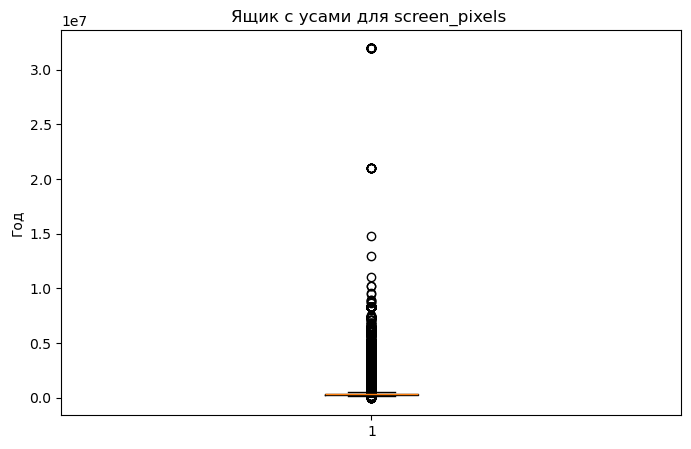

In [101]:
plt.figure(figsize=(8, 5))
plt.boxplot(df_prepared.screen_pixels)
plt.ylabel('Год')
plt.title('Ящик с усами для screen_pixels ');

In [102]:
def calculate_outliers_3sigma(data):
    low = data.mean() - 3 * data.std()
    high = data.mean() + 3 * data.std()
    boundaries = (low, high)
    
    return boundaries

In [103]:
boundaries = calculate_outliers_3sigma(df_prepared.screen_pixels)
is_outlier_screen_pixels = (df_prepared['screen_pixels'] < boundaries[0]) | (df_prepared['screen_pixels'] > boundaries[1]) 
print("Количество выбросов:", is_outlier_screen_pixels.sum()) 
print("Границы для нормальных значений года выпуска, используя правило 3х сигм:", boundaries)

Количество выбросов: 33683
Границы для нормальных значений года выпуска, используя правило 3х сигм: (-1534584.951002683, 2756345.7159381625)


In [104]:
df_prepared.loc[df_prepared['screen_pixels'] > int(boundaries[1]), 'screen_pixels'] = int(boundaries[1])

In [105]:
df_prepared.loc[df_prepared['screen_pixels'] < int(boundaries[0]), 'screen_pixels'] = int(boundaries[0])

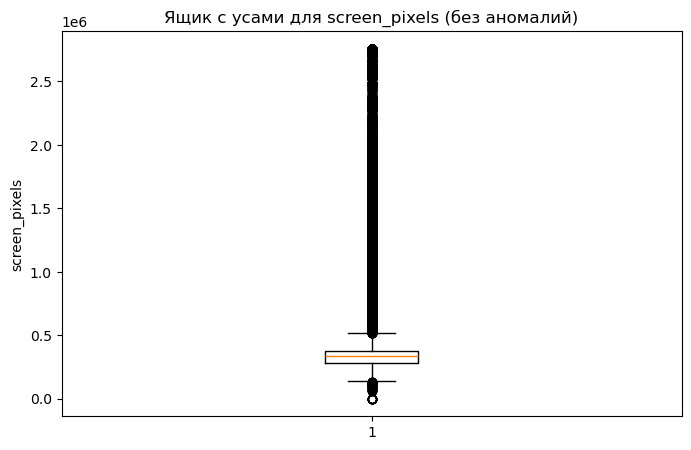

In [106]:
plt.figure(figsize=(8, 5))
plt.boxplot(df_prepared.screen_pixels)
plt.ylabel('screen_pixels')
plt.title('Ящик с усами для screen_pixels (без аномалий)');

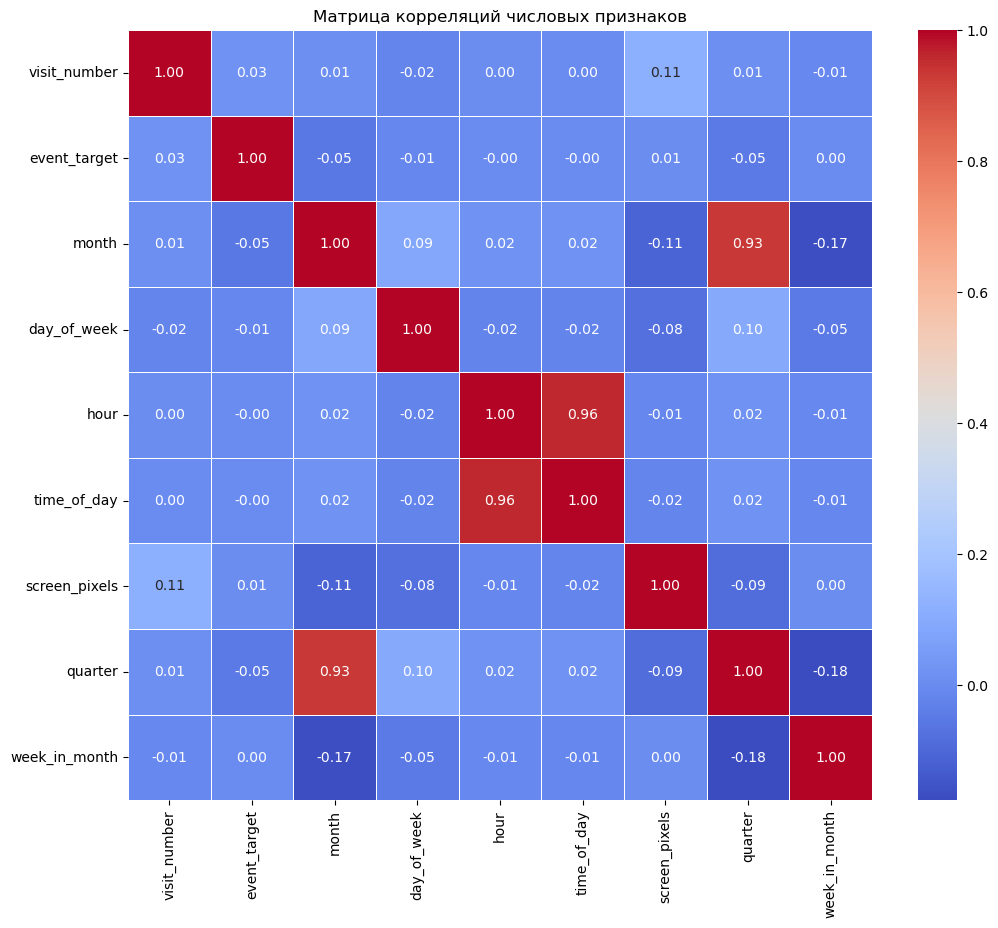


Основные корреляции:
1. Положительная корреляция между 'visit_number' и 'event_target': 0.025319736181754163
2. Положительная корреляция между 'screen_pixels' и 'hour': -0.01253432399671453
3. Отрицательная корреляция между 'day_of_week' и 'quarter': 0.09704276026102869


In [107]:
# Выбор числовых признаков для анализа корреляций
numeric_columns = df_prepared.select_dtypes(include=['int32', 'int64', 'float64']).columns
correlation_matrix = df_prepared[numeric_columns].corr()

# Построение heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица корреляций числовых признаков')
plt.show()

# Выводы по основным корреляциям
print("\nОсновные корреляции:")
print("1. Положительная корреляция между 'visit_number' и 'event_target':", correlation_matrix.loc['visit_number', 'event_target'])
print("2. Положительная корреляция между 'screen_pixels' и 'hour':", correlation_matrix.loc['screen_pixels', 'hour'])
print("3. Отрицательная корреляция между 'day_of_week' и 'quarter':", correlation_matrix.loc['day_of_week', 'quarter'])

## Data Preparation

In [49]:
df_prepared.reset_index(drop=True, inplace=True)

In [50]:
# Сохраним в переменную numerical имена всех числовых признаков нашего датасета
numerical = df_prepared.select_dtypes(include=['int64', 'float64']).columns

# Сохраним в переменную categorical имена всех категориальных признаков нашего датасета
categorical = df_prepared.select_dtypes(include=['object']).columns

print(numerical)
print(categorical)

Index(['visit_number', 'event_target', 'month', 'day_of_week', 'hour',
       'time_of_day', 'screen_pixels', 'quarter', 'week_in_month'],
      dtype='object')
Index(['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_model', 'device_browser', 'geo_country', 'geo_city'],
      dtype='object')


In [51]:
df_prepared.head(1000).to_csv('data/df_prepared_2.csv', index=False) 

In [52]:
from sklearn.preprocessing import OneHotEncoder

# Инициализация OneHotEncoder с правильными параметрами
encoder = OneHotEncoder(
    min_frequency=5,          # Оставлять категории, встречающиеся минимум 5 раз
    max_categories=7,        # Оставлять только 10 самых частых категорий
    dtype='int8',             # Используем 8-битные целые числа 
    handle_unknown='ignore',  # Игнорировать неизвестные категории при преобразовании
    sparse_output=False       # Возвращать обычный массив вместо разреженного
)

# Обучение на категориальных признаках
encoder.fit(df_prepared[categorical])

# Преобразование и добавление в DataFrame
encoded_features = encoder.transform(df_prepared[categorical])
df_prepared.loc[:, encoder.get_feature_names_out()] = encoded_features


In [53]:
# Удаляем только те столбцы, которые существуют
df_prepared = df_prepared.drop(columns=categorical, errors='ignore')  # errors='ignore' предотвратит ошибку
df_prepared.head()

,visit_number,event_target,month,day_of_week,hour,time_of_day,screen_pixels,quarter,week_in_month,utm_source_BHcvLfOaCWvWTykYqHVe,...,geo_country_Ukraine,geo_country_United States,geo_country_infrequent_sklearn,geo_city_(not set),geo_city_Kazan,geo_city_Krasnodar,geo_city_Moscow,geo_city_Saint Petersburg,geo_city_Yekaterinburg,geo_city_infrequent_sklearn
0,1,0,11,2,14,2,259200,4,4,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,11,6,8,1,328790,4,2,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,12,1,2,0,259200,4,4,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,5,5,5,0,308898,2,5,0,...,0,0,0,0,0,0,1,0,0,0
4,2,0,5,5,5,0,308898,2,5,0,...,0,0,0,0,0,0,1,0,0,0


In [54]:
#df_prepared.to_csv('data/df_prepared_1.csv', index=False) 

## Modeling

In [55]:
#df_prepared = pd.read_csv('data/df_prepared_1.csv', low_memory=False)
df_prepared.shape

(1860034, 89)

In [56]:
df_prepared.head(100).to_csv('data/df_prepared_3.csv', index=False) 

In [57]:
X = df_prepared.drop(['event_target'], axis=1)
y = df_prepared['event_target']

In [124]:
# Удаление названий столбцов
X = X.values  # Преобразует датафрейм в массив NumPy

In [125]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.3,       # доля тестовой выборки 
    random_state=42,     # для воспроизводимости
    stratify=y           # сохраняет распределение классов как в исходных данных
)

### Модель: случайный лес

In [126]:
# Сетка гиперпараметров для поиска
param_grid = {
    'n_estimators': [100],  # Количество деревьев
    'max_depth': [10],  # Максимальная глубина дерева
    'min_samples_split': [2, 5],  # Минимальное количество образцов для разделения узла
    'min_samples_leaf': [1],    # Минимальное количество образцов в листе
    'max_features': ['sqrt']  # Количество фичей для рассмотрения при разделении
}

# Создание модели
model_forest = RandomForestClassifier(class_weight='balanced',random_state=42)

# Кросс-валидационный поиск с ROC-AUC
grid_search_forest = GridSearchCV(
    estimator=model_forest,
    param_grid=param_grid,
    scoring='roc_auc',  # Используем ROC-AUC вместо accuracy
    cv=5,               # Количество фолдов
    n_jobs=-1,          # Использовать все ядра CPU
    verbose=1           # Вывод информации о процессе
)

# Запуск поиска на тренировочных данных
grid_search_forest.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1], 'min_samples_split': [2, 5],
                         'n_estimators': [100]},
             scoring='roc_auc', verbose=1)

In [127]:
# Лучшая модель
best_model_forest = grid_search_forest.best_estimator_
best_score_forest=grid_search_forest.best_score_
print(f'Лучшие параметры: {grid_search_forest.best_params_}')
print(f'Лучшая точность (кросс-валидация): {best_score_forest:.2f}')

Лучшие параметры: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Лучшая точность (кросс-валидация): 0.69


In [58]:
#Лучшие параметры: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
#Лучшая точность (кросс-валидация): 0.69

### Модель: многослойный персептрон

In [285]:
# Определяем сетку гиперпараметров
param_grid = {
    'hidden_layer_sizes':[(100, 50)],  # 2 слоя: 100 и 50 нейронов
    'activation': ['relu'],  # Функции активации
    'solver': ['adam'],  # Алгоритмы оптимизации
    'alpha': [ 0.1],  # Параметр регуляризации
    'learning_rate': ['adaptive']  # Тип обучения 
}

In [286]:
mlp = MLPClassifier(random_state=42, max_iter=2000)

In [287]:
# Используем GridSearchCV для поиска лучших параметров
grid_search_mlp = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search_mlp.fit(X_train, y_train)   

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=2000, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [0.1],
                         'hidden_layer_sizes': [(100, 50)],
                         'learning_rate': ['adaptive'], 'solver': ['adam']},
             scoring='roc_auc')

In [288]:
# Лучшая модель
best_model_mlp = grid_search_mlp.best_estimator_
best_score_mlp=grid_search_mlp.best_score_
print(f'Лучшие параметры: {grid_search_mlp.best_params_}')
print(f'Лучшая точность (кросс-валидация): {best_score_mlp:.2f}')

Лучшие параметры: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
Лучшая точность (кросс-валидация): 0.50


In [275]:
#Лучшие параметры: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'solver': 'adam'}
#Лучшая точность (кросс-валидация): 0.69

### Модель: логистическая регрессия

In [301]:
param_grid = {
    'C': [1, 10],  # Сила регуляризации
    'penalty': ['l1', 'l2'],               # Тип регуляризации
    'solver': ['liblinear','saga']        # Алгоритм оптимизации (поддерживает L1 и L2)
}

In [302]:
logreg =  LogisticRegression(max_iter=1000, random_state=42,class_weight='balanced')

In [303]:
# Кросс-валидационный поиск
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,              # Количество фолдов
    n_jobs=-1,         # Использовать все ядра CPU
    verbose=1
)

In [304]:
grid_search.fit(X_train, y_train)  

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='roc_auc', verbose=1)

In [305]:
# Лучшая модель
best_model_LR = grid_search.best_estimator_
best_score_logic=grid_search.best_score_
print(f'Лучшие параметры: {grid_search.best_params_}')
print(f'Лучшая точность (кросс-валидация): {best_score_logic:.2f}')

Лучшие параметры: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Лучшая точность (кросс-валидация): 0.67


In [ ]:
#Лучшие параметры: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

### Результат Modelling

In [ ]:
# Лучший резултат (кросс-валидация) у модели многослойного персептрона

In [66]:
print(f'модель Логистическая регрессия: 0.67')
print(f'модель Многослойный персептрон: 0.50')
print(f'модель Cлучайного леса: 0.69')

модель Логистическая регрессия: 0.67
модель Многослойный персептрон: 0.50
модель Cлучайного леса: 0.69


### Матрица ошибок для лучшей модели

In [63]:
pred_test = best_model_forest.predict(X_test)

In [65]:
confusion_matrix(y_test, pred_test  )

array([[298712, 244205],
       [  4049,  11045]], dtype=int64)